In [ ]:
from project1 import HeatConduction2DTransientFE, HeatConduction2DTransientCN, HeatConduction2D, steady_grid_analysis, transient_temporal_grid_analysis, transient_spatial_grid_analysis
import time

In [ ]:
M, N = 50, 50
width, height = 1.0, 1.0
alpha = 1.0e-3
dt = 0.1
time_steps = 100
T_init = 0
T_top, T_bottom, T_left, T_right = 100, 0, 100, 100


In [ ]:
## Steady state
heat_conduction = HeatConduction2D(M, N, width, height, T_top, T_bottom, T_left, T_right)
start = time.time()
T_grid = heat_conduction.solve()
end = time.time()
print(f"Time taken for solving the system: {end-start:.4f} seconds")
heat_conduction.plot()

In [ ]:
simulation = HeatConduction2DTransientFE(M, N, width, height, T_init, T_top, T_bottom, T_left, T_right, alpha, dt, time_steps)
simulation.solve()
simulation.plot_centerline()

In [ ]:
simulation.plot_temperature_evolution(num_of_points=8)

In [ ]:
# Crank-Nicolson method
simulation = HeatConduction2DTransientCN(M, N, width, height, T_init, T_top, T_bottom, T_left, T_right, alpha, dt, time_steps)
simulation.solve()
simulation.plot_centerline()

In [ ]:
simulation.plot_temperature_evolution(num_of_points=8)

In [ ]:
# perform steady state grid analysis
grid_sizes = [[10, 10], [20, 20], [50, 50], [100, 100], [200, 200]]
benchmark_grid = [250, 250]
errors, centerline_temps = steady_grid_analysis(grid_sizes, width, height, T_top, T_bottom, T_left, T_right, benchmark_grid)


In [ ]:
grid_sizes = [[10, 10], [20, 20], [50, 50], [100, 100]]
alpha = 1.0e-3
dt = 0.1
time_steps = 100
benchmark_grid = [200, 200]
method = "Crank-Nicolson"
errors, centerline_temps = transient_spatial_grid_analysis(grid_sizes, dt, width, height, T_init, T_top, T_bottom, T_left, T_right, alpha, time_steps, benchmark_grid, method)


In [ ]:
grid_sizes = [[10, 10], [20, 20], [50, 50], [100, 100]]
alpha = 1.0e-3
dt = 0.1
time_steps = 100
benchmark_grid = [200, 200]
method = "Crank-Nicolson"
errors, centerline_temps = transient_spatial_grid_analysis(grid_sizes, dt, width, height, T_init, T_top, T_bottom, T_left, T_right, alpha, time_steps, benchmark_grid, method)


In [ ]:
grid_sizes = [[10, 10], [20, 20], [50, 50], [100, 100]]
alpha = 1.0e-3
dt = 0.1
time_steps = 100
benchmark_grid = [200, 200]
method = "Crank-Nicolson"
errors, centerline_temps = transient_spatial_grid_analysis(grid_sizes, dt, width, height, T_init, T_top, T_bottom, T_left, T_right, alpha, time_steps, benchmark_grid, method)

In [ ]:
-# temporal grid analysis
dts = [1,0.5, 0.1, 0.05, 0.01, 0.005]
M, N = 50, 50
time_steps = 10
benchmark_dt = 0.001
method = "Crank-Nicolson"
errors, centerline_temps = transient_temporal_grid_analysis(grid_sizes, dts, width, height, T_init, T_top, T_bottom, T_left, T_right, alpha, time_steps=10, benchmark_ts=0.001, method='Crank-Nicolson')

# Project 1 - Laplace Equation / Transient Heat Equation

**Author:** Mubaraq Olojo

**Course:** _ME7953_

**Semester:** Spring 2024

**AI:** _list all AI tools used for this assignment or 'N/A' otherwise_

*Note: All functions should be implemented in an external module `project1`; solutions 
should be discussed in this notebook. The notebook should be structured as a report with 
abstract, introduction, discussion of method, discussion of results, and conclusions. 
In case you are using external references, they should be listed in a bibliography. 
All figures and tables should be discussed in adequate detail. While it is necessary to 
include some code, you should attempt to use minimal code to preserve readability of 
this document (in other words: the notebook should mostly use MarkDown blocks, not code 
cells).*


## Analysis of 2D Heat Conduction Models: Steady-State and Transient State

# 2.0 Modelling Approaches

The heat equation, a fundamental partial differential equation (PDE), governs the distribution of heat (thermal energy) across time and space within a two-dimensional domain. It is mathematically represented as:

$$\frac{\partial T}{\partial t} = \alpha \left(\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2}\right)$$

where:
- $T$ is the temperature at any given point in the domain,
- $\alpha$ denotes the thermal diffusivity of the material,
- $t$ represents time,
- $x$ and $y$ are the spatial coordinates.


### Steady State Analysis

In steady-state scenarios, the temperature field reaches equilibrium, and the heat equation simplifies to the Laplace equation, indicating no change in temperature over time:

$$0 = \frac{\partial^2T}{\partial x^2} + \frac{\partial^2T}{\partial y^2}$$

This scenario allows for the use of spatial discretization to solve for temperature at various points within the domain, applying boundary conditions to determine unknown temperatures.


The domain is discretized into a grid, facilitating the numerical solution process. For a domain with $M \times N$ points, where $M$ is the number of rows and $N$ is the number of columns, we represent the solution domain $\mathbf{X}$ as follows:

$$
\mathbf{X} =
\begin{bmatrix}
    \mathbf{x}_{0}\,\mid\,
    \mathbf{x}_{1}\,\mid\,
    \mathbf{x}_{2}\,\mid\,
    \mathbf{x}_{3}\,\mid\,
    \dots\,\mid\,
    \mathbf{x}_{N-1}
\end{bmatrix}
$$

Here, $\mathbf{x}_i$ are column vectors containing $M$ entries, defined as:

$$
\mathbf{x}_i = \begin{Bmatrix}x_{0,i}\enspace x_{1,i} \> \cdots \> x_{M-1,i}\end{Bmatrix}^T
$$

The linear system of equations is constructed to solve for the temperature distribution, encapsulated as:

$$
\begin{pmatrix}
    \mathbf{A}_{0,0} & \mathbf{A}_{0,1} & 0 & \dots & 0 \\
    \mathbf{A}_{1,0} & \mathbf{A}_{1,1} & \mathbf{A}_{1,2} & \dots & 0 \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \dots & \mathbf{A}_{N-1,N-2} & \mathbf{A}_{N-1,N-1} \\
\end{pmatrix}
\begin{pmatrix}
    \mathbf{x}_{0} \\ \mathbf{x}_{1} \\ \vdots \\ \mathbf{x}_{N-1}
\end{pmatrix}
=
\begin{pmatrix}
    \mathbf{b}_{0} \\ \mathbf{b}_{1} \\ \vdots \\ \mathbf{b}_{N-1}
\end{pmatrix}
$$

$\mathbf{A}_{i,j}$ are matrices representing the relationship between points in the grid, with diagonal and off-diagonal elements indicating interactions due to the discretization process.


Using the finite difference method at an interior grid point for transient analysis, the temperature update formula can be written as:

$$
T_{k,l}^{(i+1)} = T_{k,l}^{(i)} + \frac{\alpha \Delta t}{\Delta x^2} \left( T_{k-1,l}^{(\star)} - 2T_{k,l}^{(\star)} + T_{k+1,l}^{(\star)} \right) + \frac{\alpha \Delta t}{\Delta y^2} \left( T_{k,l-1}^{(\star)} - 2T_{k,l}^{(\star)} + T_{k,l+1}^{(\star)} \right)
$$

where $(\star)$ denotes a specific point in time, depending on the numerical solution approach used. This expression encapsulates the core of transient heat conduction analysis, facilitating the exploration of how temperature evolves within the domain over time.


### Trasient State Analysis

The process by which heat diffuses through a material over time, altering temperature at each stage until a steady state is attained (if at all) is known as transient heat conduction. The following is the 2D transient heat conduction equation:

$$\frac{\partial T}{\partial t} = \alpha\left(\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2}\right)$$

This equation represents the 2D heat equation or diffusion equation for temperature (T) in Cartesian coordinates. It describes how the temperature changes over time due to the combined effects of heat conduction in the x and y directions, with α being the thermal diffusivity constant.

### Crank-Nicolson Method (Implicit)

The Crank-Nicolson method is recognized for its implicit time-stepping approach, offering a stable and accurate method for numerically solving partial differential equations, like the heat equation in thermal analysis. It characteristically averages the spatial derivatives between two consecutive time steps, $n$ and $n+1$, to achieve higher accuracy without the stringent stability constraints associated with explicit methods. The discretized form of the heat equation utilizing the Crank-Nicolson method is as follows:

\begin{aligned}
&\frac{T^{n+1}_{i,j} - T^n_{i,j}}{\Delta t} = \frac{\alpha}{2} \left[ \left( \frac{T^{n+1}_{i+1,j} - 2T^{n+1}_{i,j} + T^{n+1}_{i-1,j}}{\Delta x^2} + \frac{T^{n+1}_{i,j+1} - 2T^{n+1}_{i,j} + T^{n+1}_{i,j-1}}{\Delta y^2} \right) + \left( \frac{T^n_{i+1,j} - 2T^n_{i,j} + T^n_{i-1,j}}{\Delta x^2} + \frac{T^n_{i,j+1} - 2T^n_{i,j} + T^n_{i,j-1}}{\Delta y^2} \right) \right]
\end{aligned}

In this equation:
- $T^{n+1}_{i,j}$ and $T^n_{i,j}$ represent the temperatures at grid point $(i,j)$ at the next ($n+1$) and current ($n$) time steps, respectively.
- $\alpha$ denotes the thermal diffusivity of the material.
- $\Delta t$, $\Delta x$, and $\Delta y$ are the time step size and spatial step sizes in the $x$ and $y$ directions.

This formulation balances the contributions from the current and subsequent time steps, requiring the solution of a system of linear equations at each time increment due to its implicit nature. The Crank-Nicolson method is thus particularly suited for simulations where numerical stability is paramount, such as in the analysis of transient heat conduction scenarios.



### Forward Euler Method (Explicit)

An explicit time-stepping method for solving partial differential equations numerically, such as the heat equation, is the Forward Euler method. The method does not need solving a system of equations at each time step and was employed to solve the heat equation in this report, since it discretizes the time derivative and spatial second derivatives explicitly, updating the temperature field based on the current state. The heat equation can be expressed in discretized form using the Forward Euler method as follows: 


\begin{aligned}
T^{n+1}_{i,j} = T^{n}_{i,j} + \alpha \Delta t \left( \frac{T^n_{i+1,j} - 2T^n_{i,j} + T^n_{i-1,j}}{\Delta x^2} + \frac{T^n_{i,j+1} - 2T^n_{i,j} + T^n_{i,j-1}}{\Delta y^2} \right)
\end{aligned}

where:
- $T^{n+1}_{i,j}$  is the temperature at grid point $(i, j)$ and at the next time step $(n+1)$,
- $T^n_{i,j}$ represents the temperature at grid point $(i, j)$ and at the current time step $n$,
- $\alpha$ denotes the thermal diffusivity of the material.
- $\Delta t$ denotes the time step size,
- $\Delta x$ and $\Delta y$ are the spatial step sizes in the $x$ and $y$ directions, respectively.


This formulation makes it easier to examine transient heat conduction events since it makes updating the temperature field over time simple. Because the Forward Euler approach is explicit, it can solve problems where stability requirements are met computationally efficiently because it does not involve solving a matrix equation at each step.

In this project, you are asked to illustrate temperature distributions for a 2D scenario
illustrated by the image below:

![title](project1.svg)

Using cartesian coordinates, the transient heat equation is written as

$$
\frac{\partial T}{\partial t} = \alpha \Delta T
$$

whereas steady state conditions are found by solving the Laplace equation

$$
\Delta T = 0
$$

In this assignment, you are asked to solve (and illustrate results) for the following 
scenarios:

1. Steady state solution 

2. Transient solution

## Part 1: Stationary Solution

1. Illustrate that results follow expectations (there is a standard solution for 
$T_a = T_b = T_c \neq T_d$, a.k.a. 'Scenario 1'); this case should involve a grid study to show proper
convergence.
2. Investigate impact of aspect ratio (square vs. aspect ratio of 2:3) for Scenario 1
3. Investigate impact of temperature choices for a square geometry: you should 
investigate (a) all *unique* configurations with two pairs of equal temperatures (rotated 
and/or flipped configurations do not count), and (b) at least two different cases that 
involve three temperature levels.

## Part 2: Transient Solution

Implement two approaches (your choice of forward Euler, backward Euler, and Crank-Nicolson). 
You should investigate Scenario 1 for a square geometry, and include a grid study to show convergence.

In [57]:
import numpy as np
from project1 import HeatConduction2D, HeatConduction2DTransient
import time

In [59]:
M = 200
N = 200

Boundary conditions calculated in 0.000000 seconds
Interior points calculated in 0.075431 seconds
Solution calculated in 0.712057 seconds


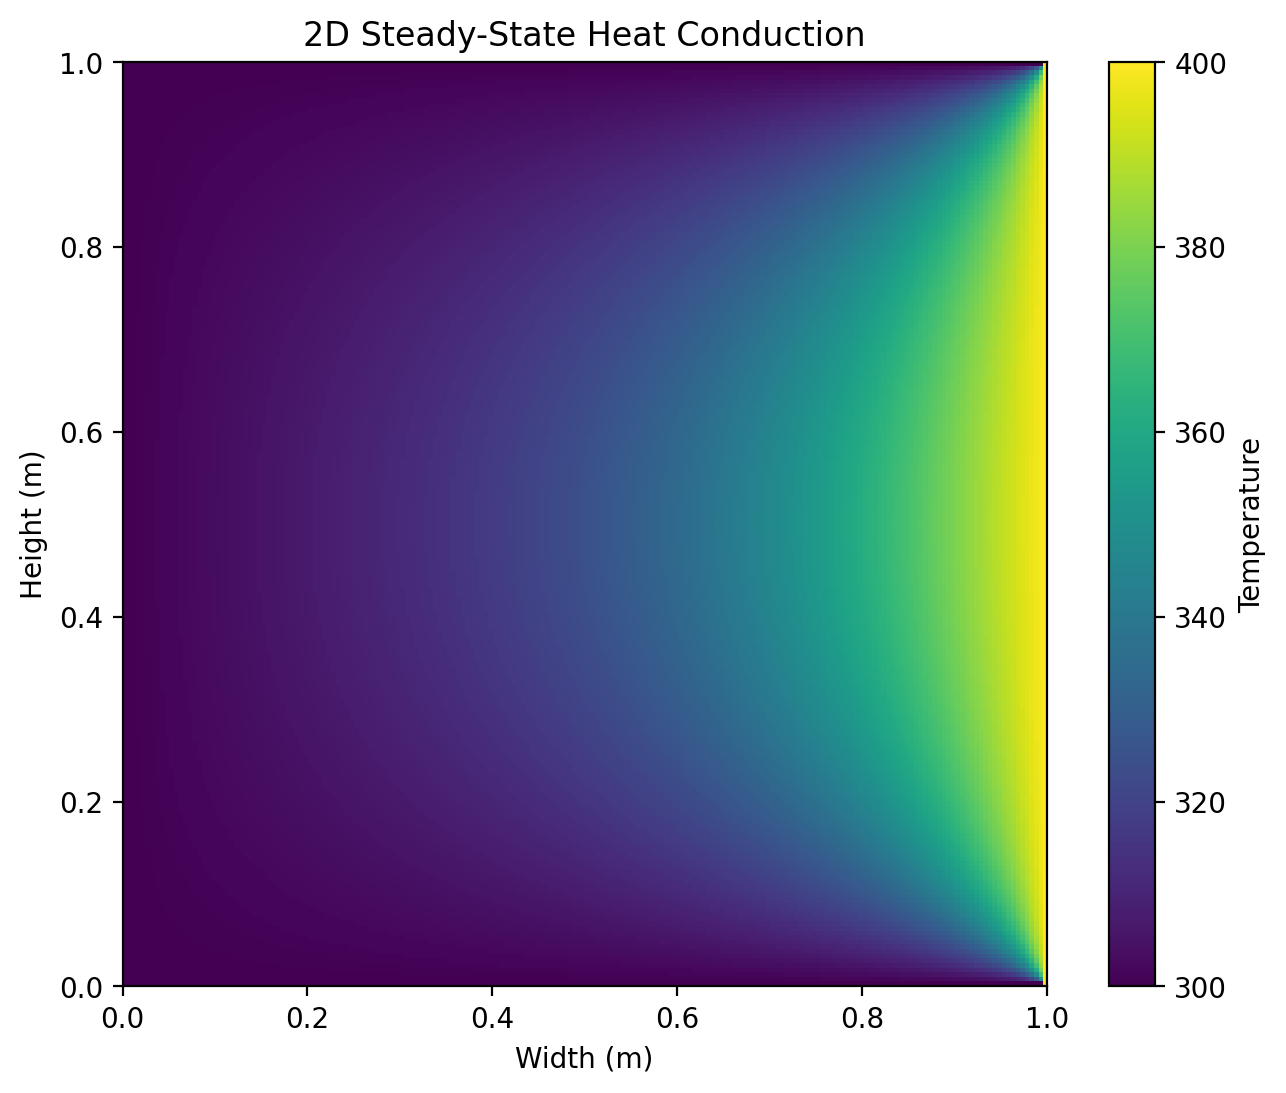

In [62]:
width, height = 1.0, 1.0
T_top, T_bottom, T_left, T_right = 300, 300, 300, 400
vectorized = True
heat_conduction = HeatConduction2D(M, N, width, height, T_top, T_bottom, T_left, T_right, vectorized=vectorized)
T_grid = heat_conduction.solve()
heat_conduction.plot()

Boundary conditions calculated in 0.000000 seconds
Interior points calculated in 0.079930 seconds
Solution calculated in 0.306842 seconds
Time taken for solving the system: 0.3068 seconds


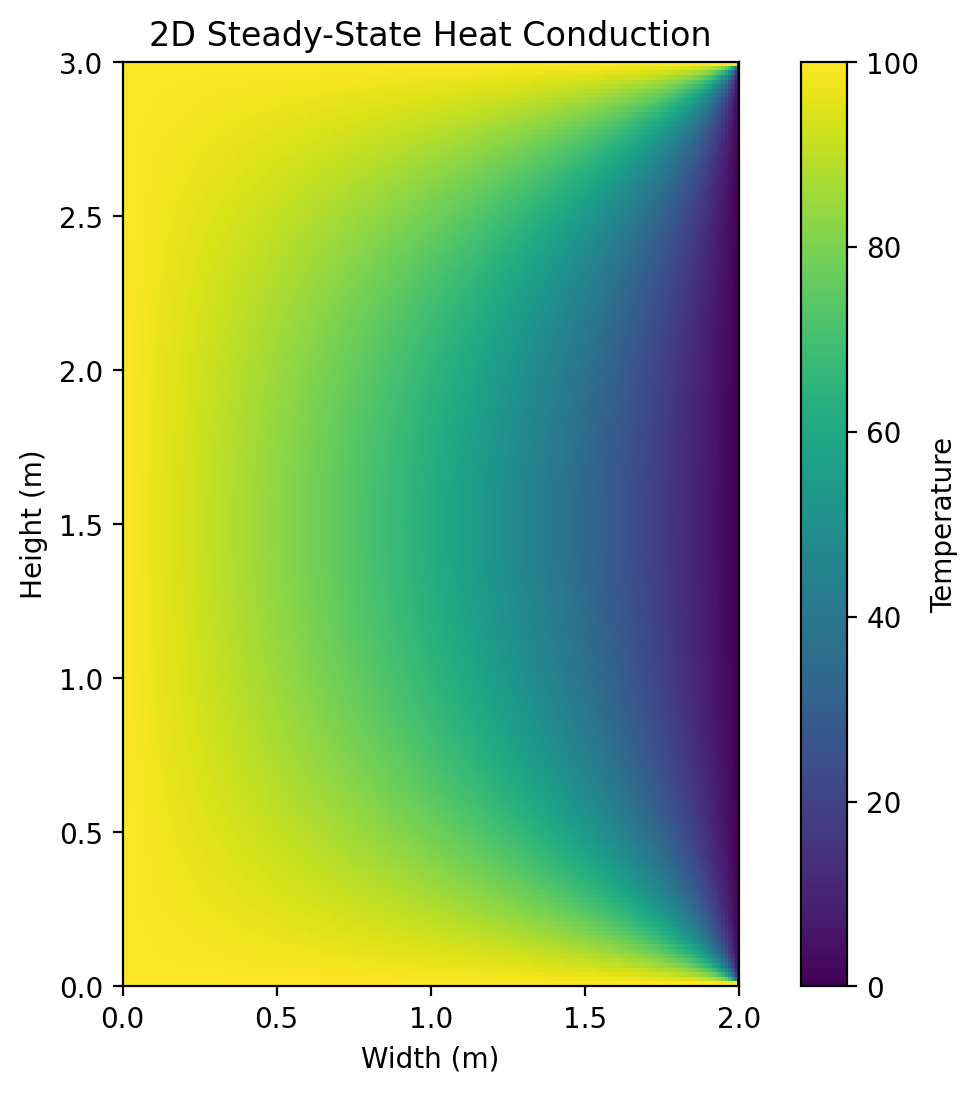

In [56]:
M = 200
N = 200
width, height = 2.0, 3.0
T_top, T_bottom, T_left, T_right = 100, 100, 100, 0
vectorized = True
heat_conduction = HeatConduction2D(M, N, width, height, T_top, T_bottom, T_left, T_right, vectorized=vectorized)
start = time.time()
T_grid = heat_conduction.solve()
end = time.time()
print(f"Time taken for solving the system: {end-start:.4f} seconds")
heat_conduction.plot()

Boundary conditions calculated in 0.000000 seconds
Interior points calculated in 0.036633 seconds
Solution calculated in 0.306679 seconds
Time taken for solving the system: 0.3067 seconds


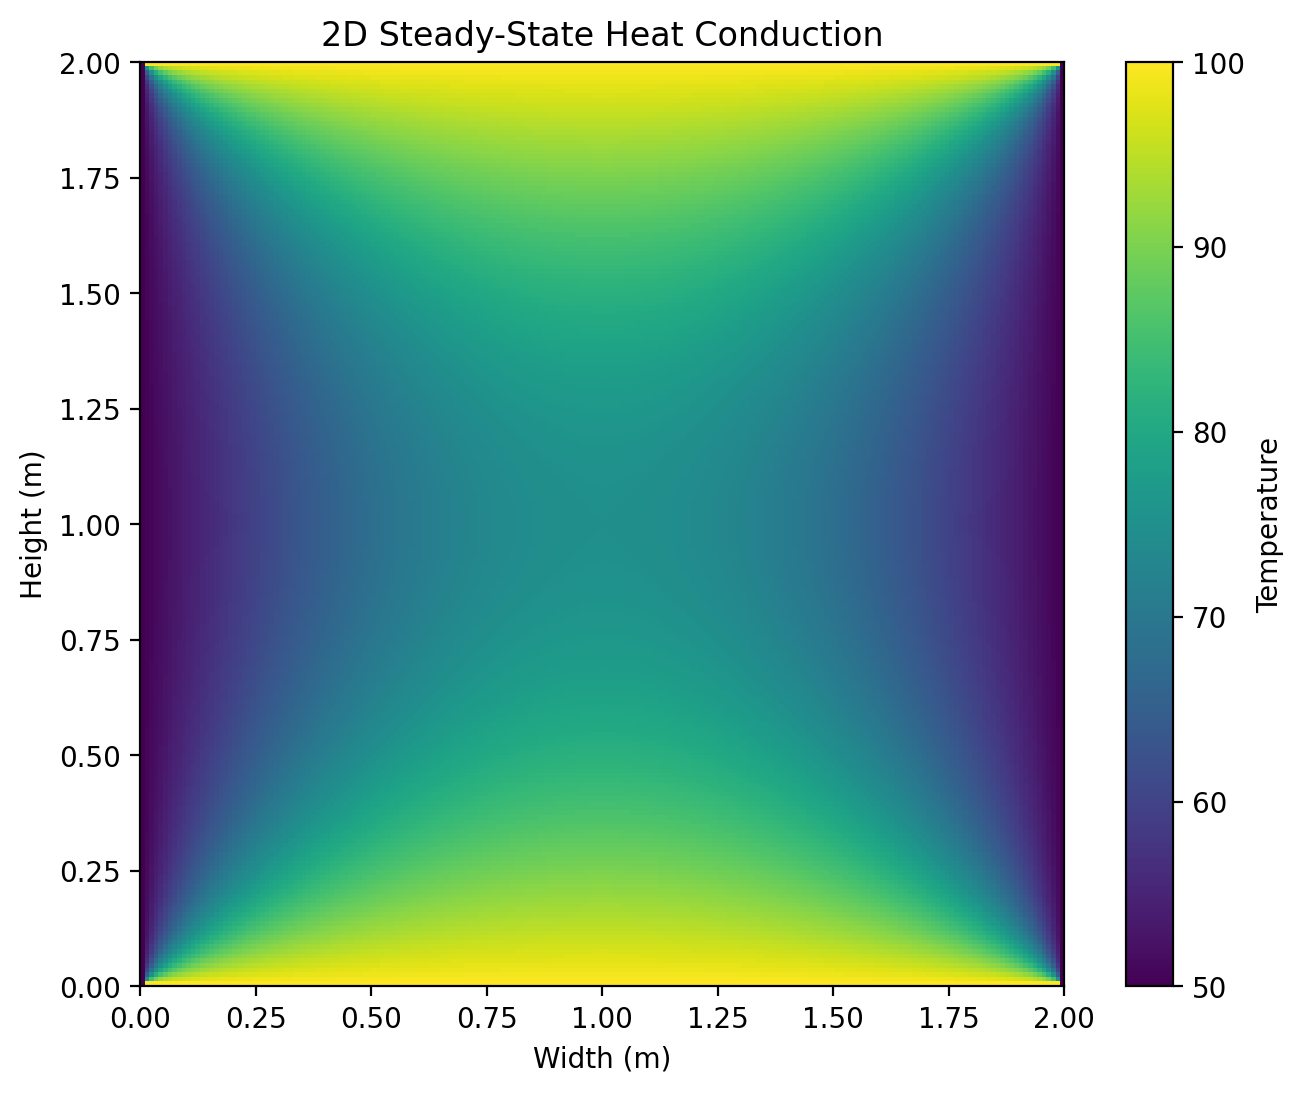

In [45]:
M = 200
N = 200
width, height = 2.0, 2.0
T_top, T_bottom, T_left, T_right = 100, 100, 50, 50
vectorized = True
heat_conduction = HeatConduction2D(M, N, width, height, T_top, T_bottom, T_left, T_right, vectorized=vectorized)
start = time.time()
T_grid = heat_conduction.solve()
end = time.time()
print(f"Time taken for solving the system: {end-start:.4f} seconds")
heat_conduction.plot()

Boundary conditions calculated in 0.001554 seconds
Interior points calculated in 0.031708 seconds
Solution calculated in 0.224733 seconds
Time taken for solving the system: 0.2247 seconds


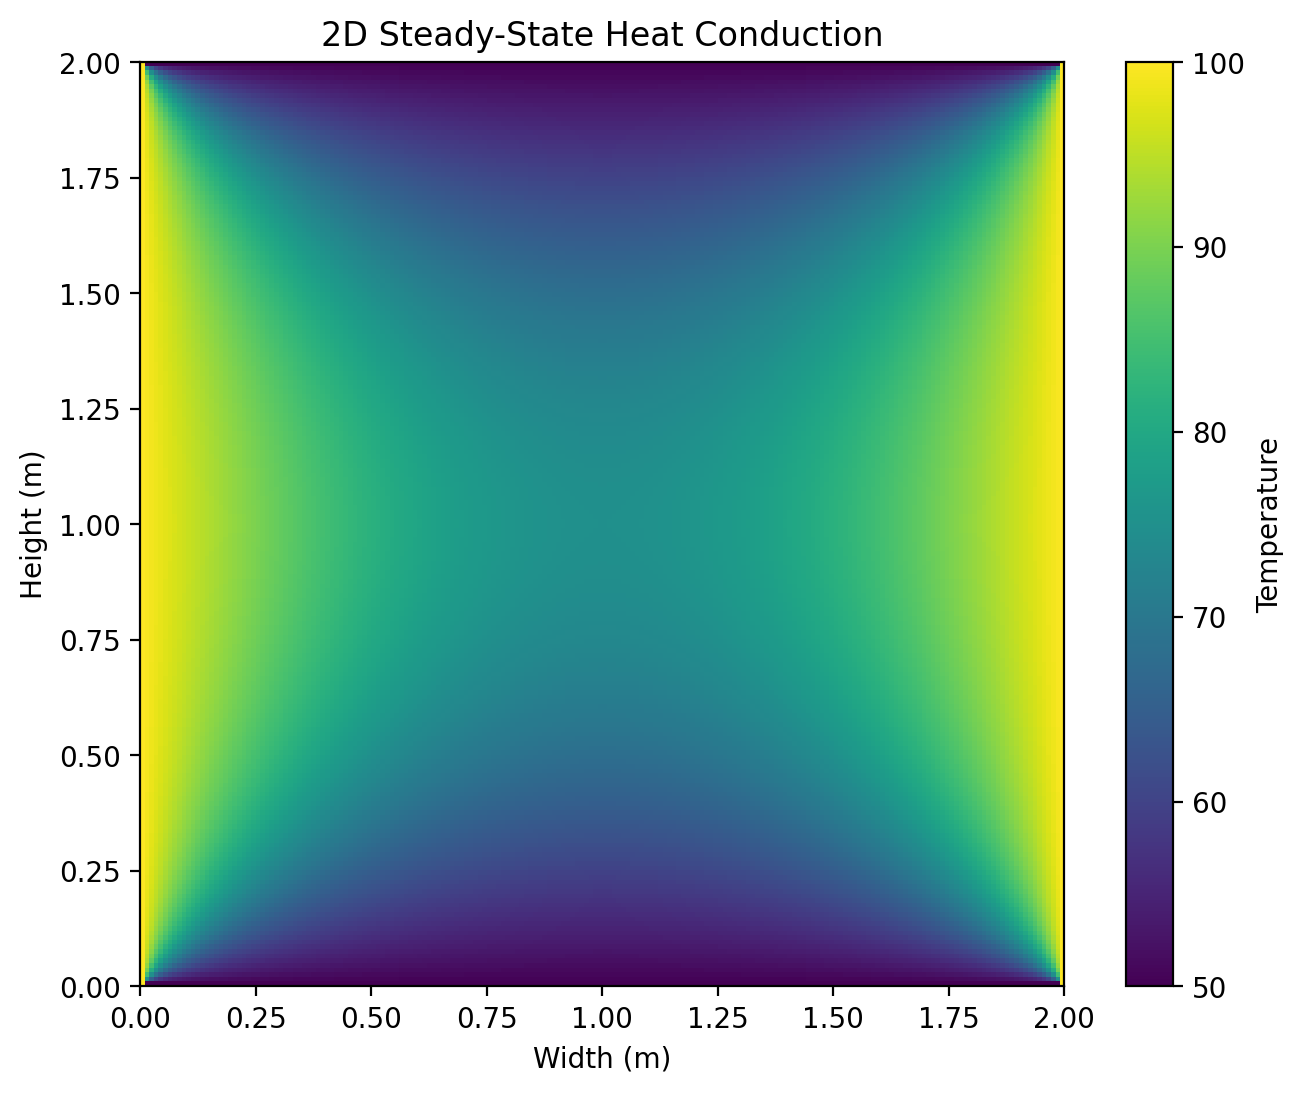

In [46]:
M = 200
N = 200
width, height = 2.0, 2.0
T_top, T_bottom, T_left, T_right = 50, 50, 100, 100
vectorized = True
heat_conduction = HeatConduction2D(M, N, width, height, T_top, T_bottom, T_left, T_right, vectorized=vectorized)
start = time.time()
T_grid = heat_conduction.solve()
end = time.time()
print(f"Time taken for solving the system: {end-start:.4f} seconds")
heat_conduction.plot()

Boundary conditions calculated in 0.000000 seconds
Interior points calculated in 0.032309 seconds
Solution calculated in 0.235007 seconds
Time taken for solving the system: 0.2350 seconds


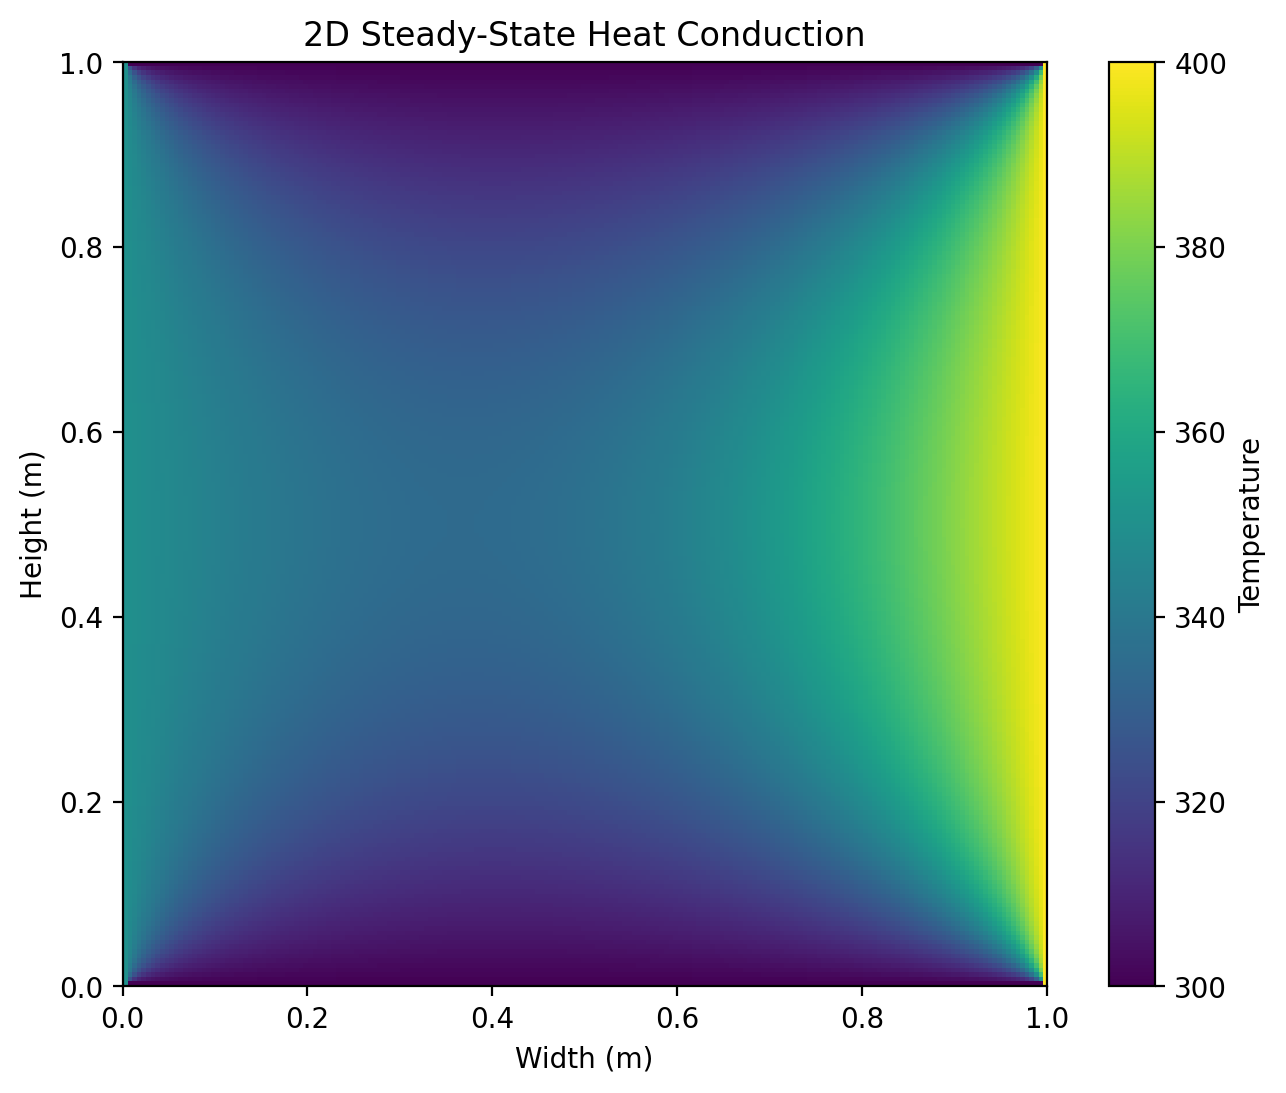

In [47]:
M = 200
N = 200
width, height = 1.0, 1.0
T_top, T_bottom, T_left, T_right = 300, 300, 350, 400
vectorized = True
heat_conduction = HeatConduction2D(M, N, width, height, T_top, T_bottom, T_left, T_right, vectorized=vectorized)
start = time.time()
T_grid = heat_conduction.solve()
end = time.time()
print(f"Time taken for solving the system: {end-start:.4f} seconds")
heat_conduction.plot()

Boundary conditions calculated in 0.001615 seconds
Interior points calculated in 0.032738 seconds
Solution calculated in 0.295637 seconds
Time taken for solving the system: 0.2967 seconds


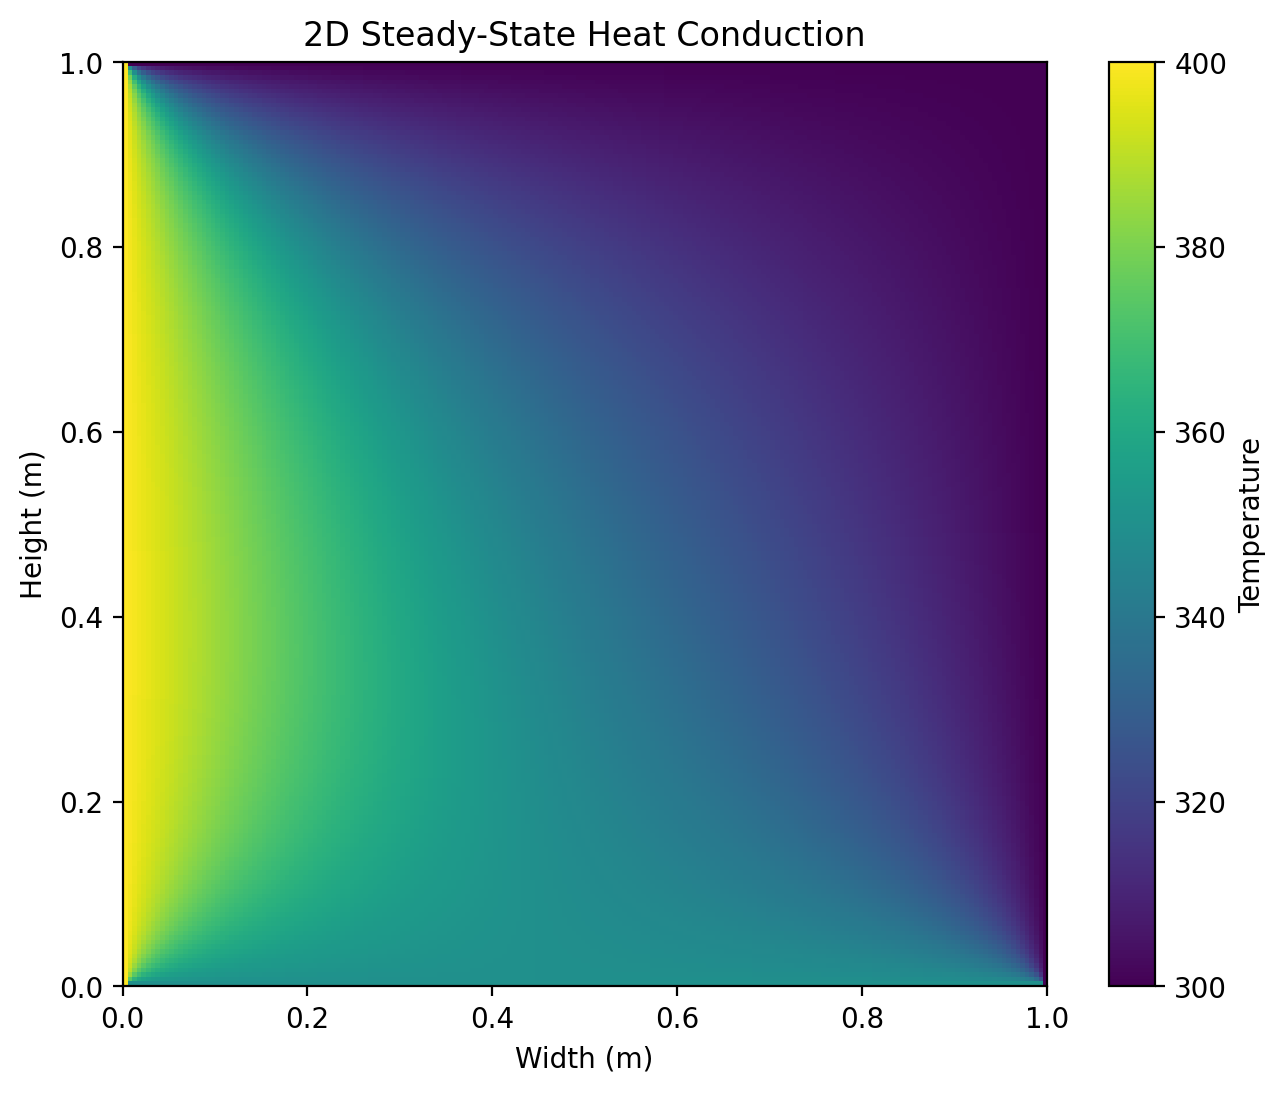

In [48]:
M = 200
N = 200
width, height = 1.0, 1.0
T_top, T_bottom, T_left, T_right = 300, 350, 400, 300
vectorized = True
heat_conduction = HeatConduction2D(M, N, width, height, T_top, T_bottom, T_left, T_right, vectorized=vectorized)
start = time.time()
T_grid = heat_conduction.solve()
end = time.time()
print(f"Time taken for solving the system: {end-start:.4f} seconds")
heat_conduction.plot()

Boundary conditions calculated in 0.000000 seconds
Interior points calculated in 0.012638 seconds
Solution calculated in 0.040939 seconds


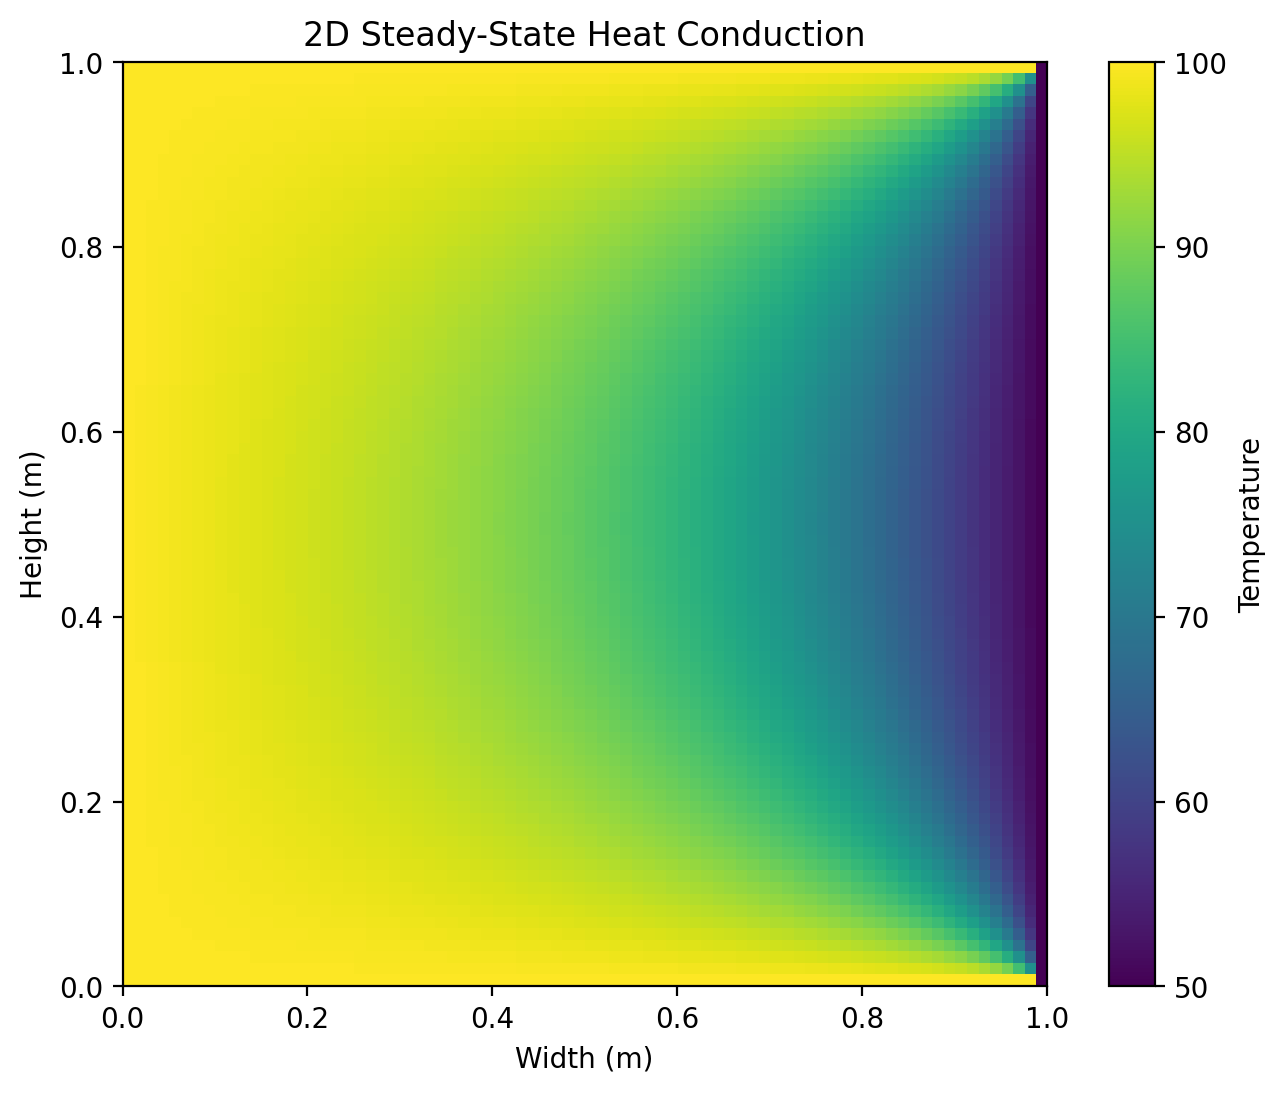

In [53]:
    # # Scenario 1: Grid Study for Convergence with initial grid size 80x80
    # M, N = 80, 80
    # width, height = 1.0, 1.0
    # T_top, T_bottom, T_left, T_right = 100, 100, 100, 50  # Scenario 1 boundary conditions
    # vectorized = True

    # # Initialize the heat conduction model
    # heat_conduction_50 = HeatConduction2D(M, N, width, height, T_top, T_bottom, T_left, T_right, vectorized=vectorized)

    # # Solve the model
    # T_grid_50 = heat_conduction_50.solve()

    # # Now, let's attempt to plot again
    # heat_conduction_50.plot()


Transient


In [ ]:
# Parameters
M, N = 80, 80
width, height = 1.0, 1.0
T_init = 0
T_top, T_bottom, T_left, T_right = 100, 100, 100, 0
alpha = 0.0011
dt = 0.1
time_steps = 1000

# Create the solver object
solver = HeatConduction2DTransient(M, N, width, height, T_init, T_top, T_bottom, T_left, T_right, alpha, dt, time_steps)

# Solve the problem
solver.solve()
centerline_temp = np.array(solver.centerline_temps)
time_steps = len(centerline_temp)

Solution calculated over 10000 time steps.


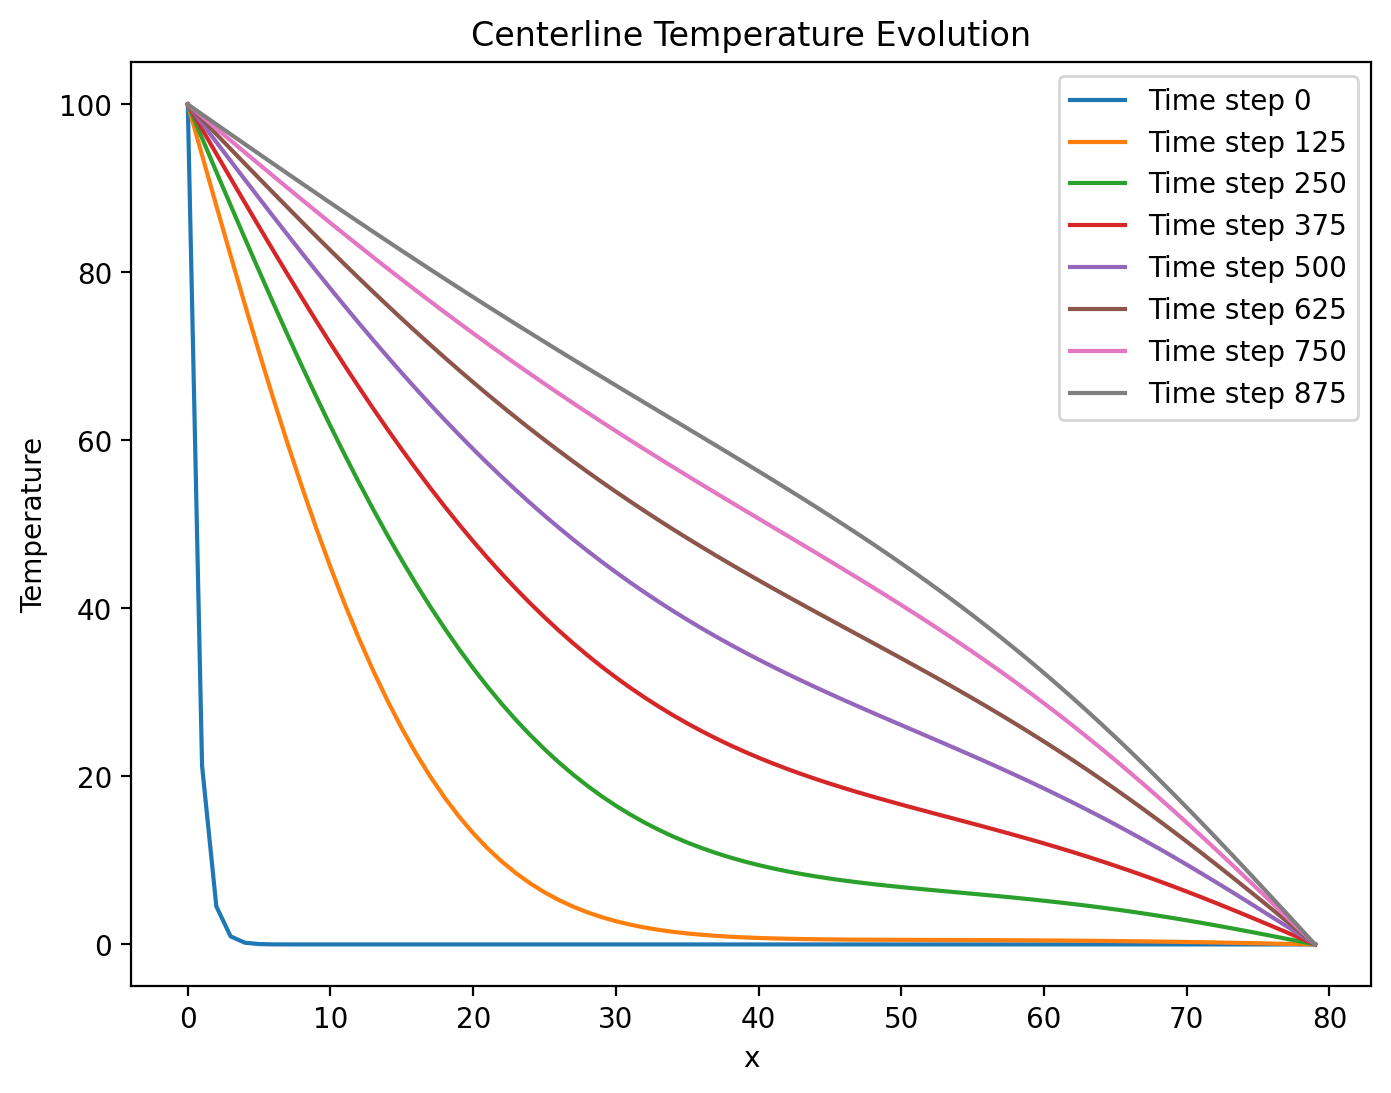

In [ ]:
solver.plot_centerline()

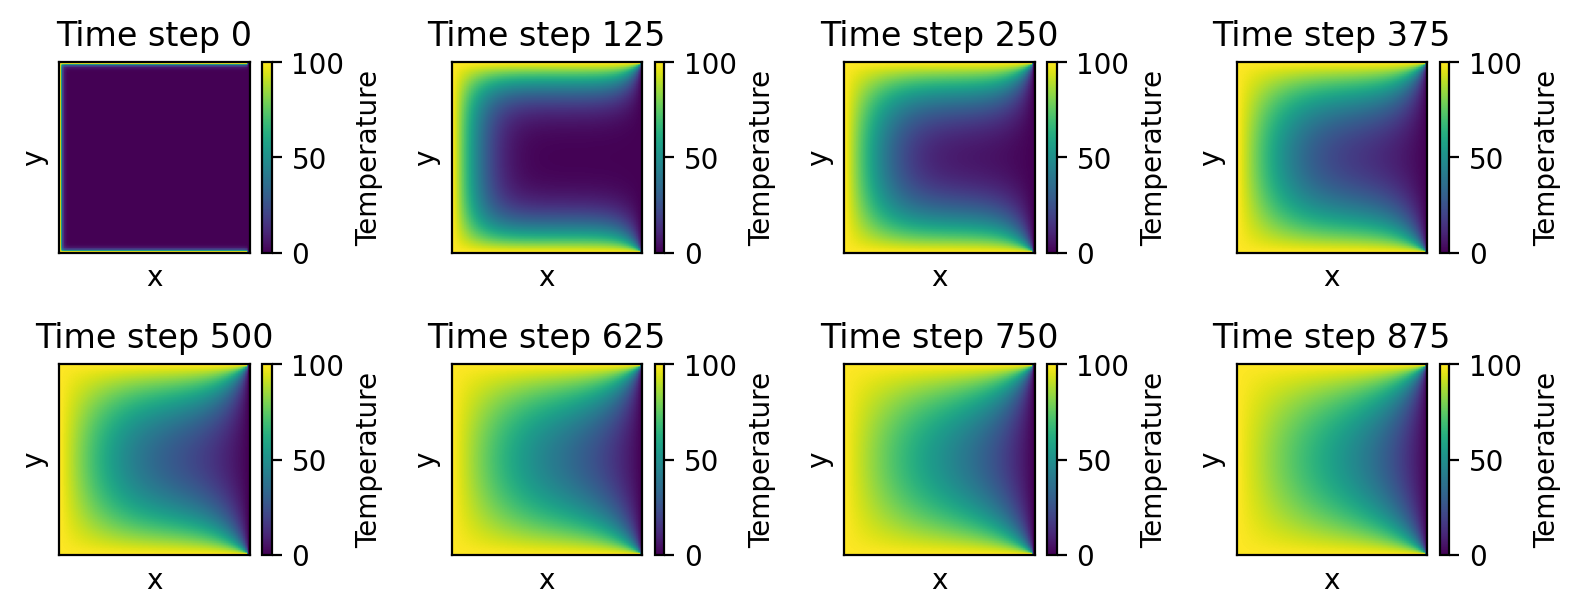

In [ ]:
solver.plot_temperature_evolution(8)

In [ ]:
# Parameters
M, N = 80, 80
width, height = 1.0, 1.0
T_init = 0
T_top, T_bottom, T_left, T_right = 100, 100, 100, 0
alpha = 0.0011
dt = 0.1
time_steps = 1000

# Create the solver object
solver = HeatConduction2DTransient(M, N, width, height, T_init, T_top, T_bottom, T_left, T_right, alpha, dt, time_steps)

# Solve the problem
solver.solve()
centerline_temp = np.array(solver.centerline_temps)
time_steps = len(centerline_temp)

## Abstract

This paper provides a thorough examination of both transient and steady-state heat conduction in a two-dimensional space, using numerical simulations to investigate different situations. We looked at how the aspect ratio, grid size, and boundary temperature configurations affected the heat dispersion in the stationary analysis. We employed the Forward Euler and Crank-Nicolson techniques for the transient analysis, focusing on grid convergence, to examine the temporal evolution of temperature. Our findings provide insightful information on thermal behavior under various circumstances, emphasizing the benefits and drawbacks of each numerical technique for simulating the physics of heat conduction.

## 1.0 Introduction

Understanding the advancement of thermal management solutions across several engineering domains, from improving building thermal efficiency to optimizing electronic device operation, depends critically on an understanding of heat conduction across a variety of materials and combinations. Because of the intrinsic complexity of thermal activity, advanced numerical techniques must be used for study and prediction, especially in multidimensional domains and dynamic scenarios. This paper is devoted to a thorough investigation of heat conduction in a two-dimensional space, examining both the steady-state and transient heat distribution in order to clarify the impact of boundary conditions, domain geometry, and numerical simulation techniques.

Finite Difference Methods (FDM) are used to discretize the heat conduction equation for the analysis of steady-state heat distribution. This allows for the investigation of the effects of different geometric configurations and boundary conditions on thermal equilibrium. The power of FDM is in its simple application to spatial discretization, which makes it a very useful tool for simulating steady-state thermal behavior in a variety of scenarios.

On the other hand, the transient analysis uses the Crank-Nicolson and Forward Euler methods to investigate the thermal field's temporal evolution. The Crank-Nicolson method offers a balanced approach through its implicit scheme, while the Forward Euler method offers simplicity and ease of implementation through its explicit nature. These methods provide complementary viewpoints on time-stepping accuracy and stability.

The study's objectives include:

1. Demonstrating the impact of spatial configuration and boundary conditions on the steady-state thermal distribution.
2. Assessing the dynamic evolution of heat within the domain under transient conditions.
3. Conducting a grid convergence study to validate the accuracy and stability of the employed numerical schemes.

Through this analysis, we aim to provide insights that can guide the optimization of thermal management strategies and enhance the understanding of thermal behavior in engineered systems. 

## 2.0 Modelling Approaches


Assume a domain with $M\times N$ points ($M$ rows and $N$ columns).

Start by dividing the solution domain $\mathbf{X}$ into $N$ columns:
$$
\mathbf{X} =
\begin{bmatrix}
    \mathbf{x}_{0}\,\mid\,
    \mathbf{x}_{1}\,\mid\,
    \mathbf{x}_{2}\,\mid\,
    \mathbf{x}_{3}\,\mid\,
    \dots\,\mid\,
    \mathbf{x}_{N-1}
\end{bmatrix}
$$
 
Here, $\mathbf{x}_i$ are column vectors with $M$ entries, i.e.
$$
\mathbf{x}_i = \begin{Bmatrix}x_{0,i}\enspace x_{1,i} \> \cdots \> x_{M-1,i}\end{Bmatrix}^T
$$
 
_As an aside, choosing columns is arbitrary; subdividing the domain into rows is equally valid._

The linear system is then set up as
 
$$
\begin{pmatrix}
    \mathbf{A}_{0,0} & \mathbf{A}_{0,1} & 0 & 0 & \dots & 0 \\
    \mathbf{A}_{1,0} & \mathbf{A}_{1,1} & \mathbf{A}_{1,2} & 0 & \dots & 0 \\
    0 & \mathbf{A}_{2,1} & \mathbf{A}_{2,2} & \mathbf{A}_{2,3} & \dots & 0 \\
    0 & 0 & \mathbf{A}_{3,2} & \mathbf{A}_{3,3} & \dots & 0 \\
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & 0 & 0 & \dots & \mathbf{A}_{N-1,N-1} \\
\end{pmatrix}
\begin{pmatrix}
    \mathbf{x}_{0} \\ \mathbf{x}_{1} \\ \mathbf{x}_{2} \\ \mathbf{x}_{3} \\ \vdots \\ \mathbf{x}_{N-1}
\end{pmatrix}
=
\begin{pmatrix}
    \mathbf{b}_{0} \\ \mathbf{b}_{1} \\ \mathbf{b}_{2} \\ \mathbf{b}_{3} \\ \vdots \\ \mathbf{b}_{N-1}
\end{pmatrix}
$$
 
where $\mathbf{x_i}$ are stacked into a single column vector. $\mathbf{A}_{i,i}$ are tri-diagonal matrices similar similar to the 1D case and $\mathbf{A}_{i,i\pm 1}$ are diagonal matrices.
 
Boundary conditions at top and bottom of the domain are in first and last row of $\mathbf{A_{i,j}}$, respectively; boundaries at left and right are represented by blocks $\mathbf{A}_{0,0}$ and $\mathbf{A}_{N-1,N-1}$, respectively. All other entries refer to interior points. Note that $\mathbf{A}_{0,1}$ and $\mathbf{A}_{1,0}$ are zero as well.
